In [2]:
import csv
import matplotlib.patches as mpatches
import datetime as dt
import os
from shapely.ops import unary_union
import cv2
import numpy as np
from shapely.geometry.polygon import Polygon
from datetime import datetime
from shapely import wkt
from shapely.geometry.point import Point
from shapely.geometry import Polygon
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from sdo.events.bboxes import convert_contours_to_polygons
import logging

def extract_bounding_boxes_from_anomaly_map(map_path, 
                                            mode="simple",
                                            mask_threshold=20, 
                                            scale=1, 
                                            min_width=2, 
                                            min_height=2, 
                                            max_width=68, 
                                            max_height=68, 
                                            gaussian_filter=False, 
                                            gaussian_filter_size=(5,5),
                                            title=""):
    """
    scale: the scale factor for bounding boxes (default 1)
    """

    pred_img = Image.open(map_path).convert("L")
    pred_img_arr = np.asarray(pred_img)

    if gaussian_filter:
        pred_img_arr = cv2.GaussianBlur(pred_img_arr, (5,5), 0)
    
    if mode == "simple":
        mask_img = pred_img_arr > mask_threshold
        inverted_pred_img_arr = np.zeros_like(pred_img_arr)
        inverted_pred_img_arr[mask_img] = pred_img_arr[mask_img]
        mask_img = inverted_pred_img_arr
    elif mode == "binary":
        ret, mask_img = cv2.threshold(pred_img_arr, mask_threshold, 255, cv2.THRESH_BINARY)
    elif mode == "otsu":
        ret, mask_img = cv2.threshold(pred_img_arr, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        raise f"thresholding method {mode} not recognized"

    plt.axis('off')
    plt.title(title)
    plt.imshow(mask_img, cmap='gray', vmin=0, vmax=255)

    contours, hierarchy = cv2.findContours(
        mask_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS)
    model_polygons = convert_contours_to_polygons(
        contours, scale=scale, min_width=min_width, min_height=min_height, max_width=max_width, max_height=max_height)

    return model_polygons

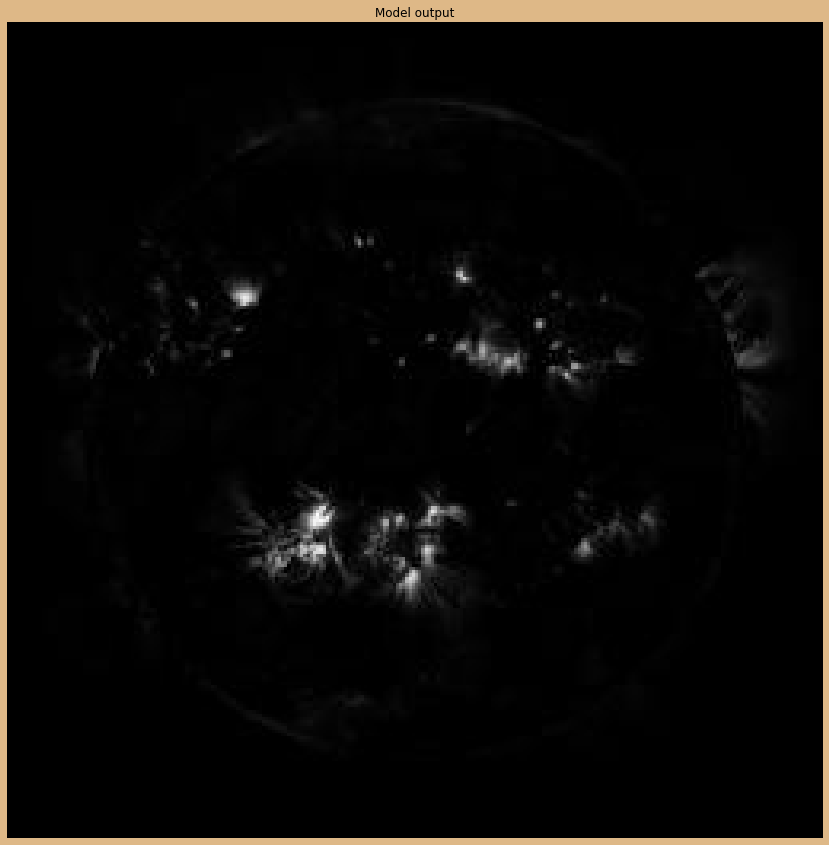

In [3]:
map_path = Path("../output/aia_171_2012-2016_256_cevae_pred/20210807-153314_cevae/predictions/2012-01-02T000000__171.jpeg")
src_img_path = Path("../data/aia_171_2012-2016/2012-01-02T000000__171.jpeg")

pred_img = Image.open(map_path).convert("L")

fig = plt.figure(figsize=(15, 15), facecolor='burlywood')
plt.axis('off')
plt.title("Model output")
plt.imshow(pred_img, cmap='gray', vmin=0, vmax=255)

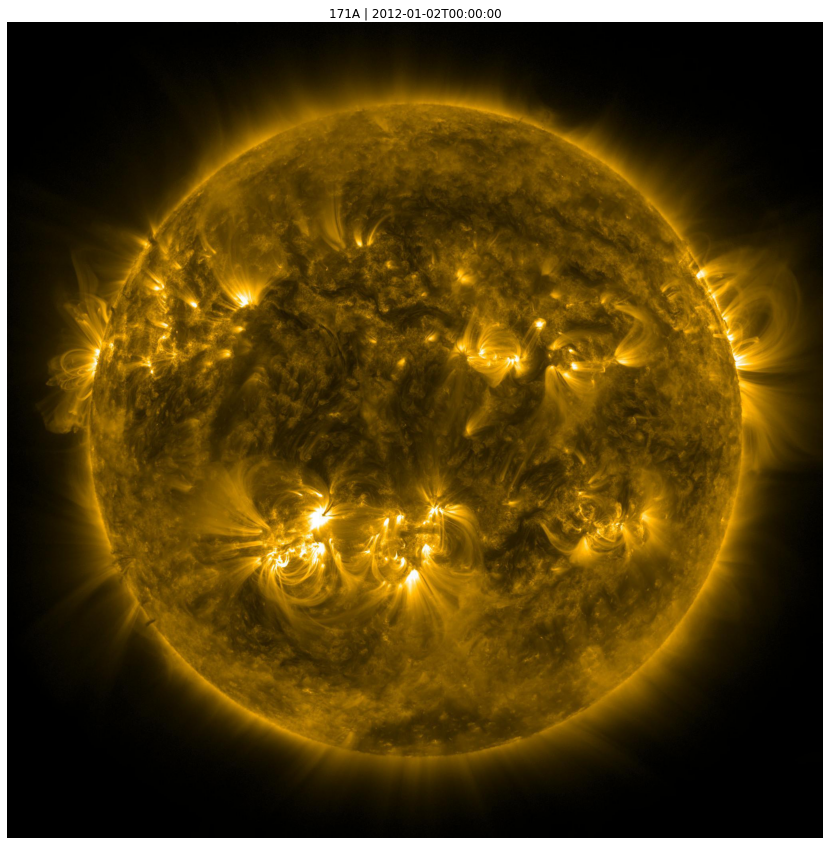

In [7]:
img = Image.open(src_img_path)
img = img.convert('RGB')
aia_wave = 171
timestamp = "2012-01-02T00:00:00"

fig = plt.figure(figsize=(15, 15))

plt.axis('off')
plt.title('{}A | {}'.format(aia_wave, timestamp))
plt.imshow(img)

In [175]:
def show_img_with_bounding_boxes(src_img_path: Path, bboxes, aia_wave, timestamp):
    img = Image.open(src_img_path)
    img = img.convert('RGB')
    img_draw = ImageDraw.Draw(img)

    fig = plt.figure(figsize=(15, 15), facecolor='burlywood')

    for bbox in bboxes:
        bbox = bbox.exterior.coords
        img_draw.line(bbox, fill="red", width=3)
        for point in bbox:
            img_draw.ellipse(
                (point[0] - 2, point[1] - 2, point[0] + 2, point[1] + 2), fill="red")

    plt.axis('off')
    plt.title('{}A | {}'.format(aia_wave, timestamp))
    plt.imshow(img)

## Simple threshold (=10)

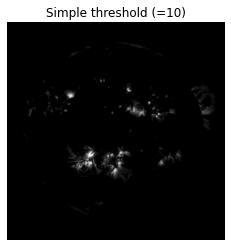

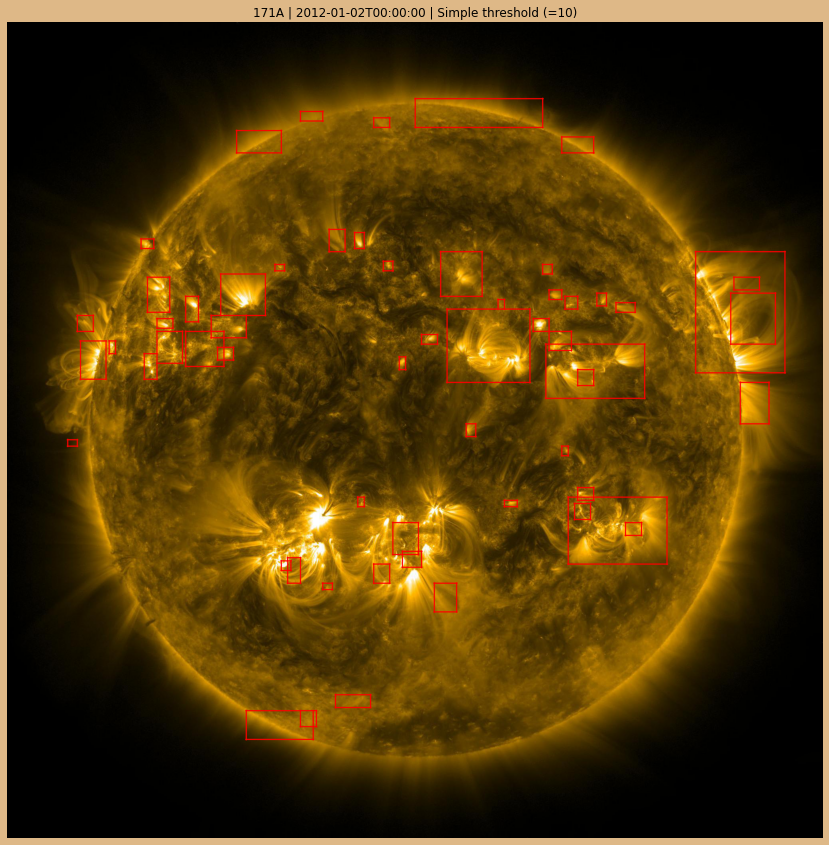

In [176]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="simple", scale=8, mask_threshold=10, title="Simple threshold (=10)")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Simple threshold (=10)")

## Simple threshold (=25)

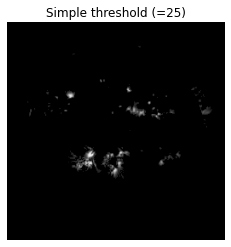

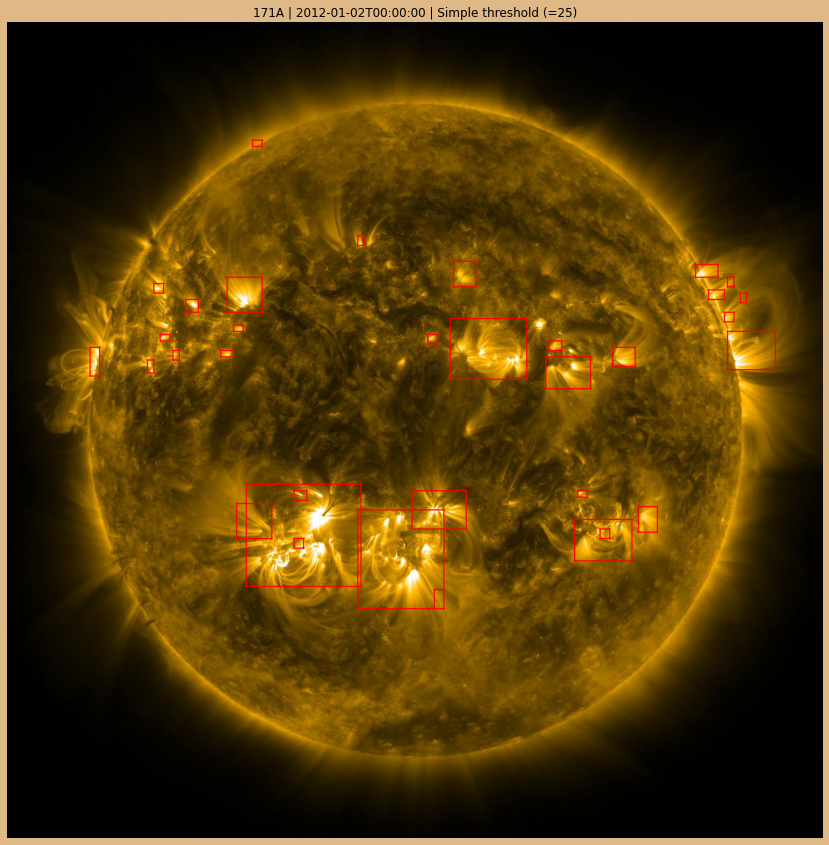

In [177]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="simple", scale=8, mask_threshold=25, title="Simple threshold (=25)")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Simple threshold (=25)")

## Simple thresholding with a gaussian filter (=25, (5, 5))

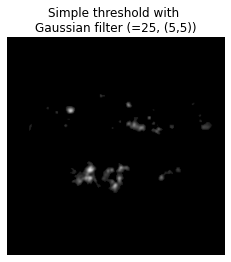

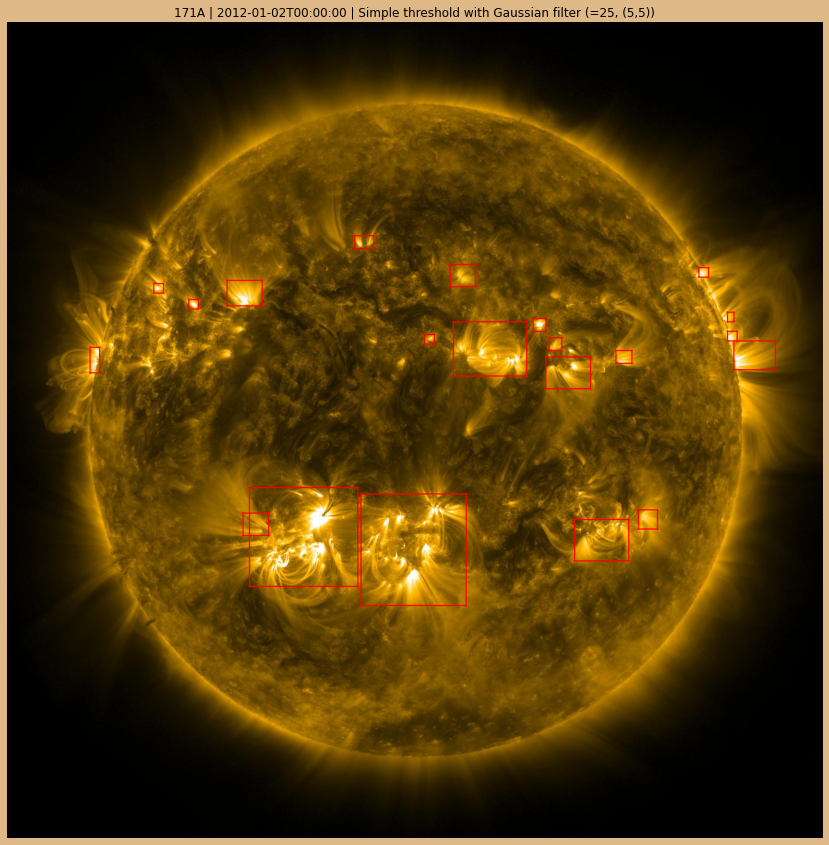

In [178]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="simple", scale=8, mask_threshold=25, gaussian_filter=True, title="Simple threshold with \nGaussian filter (=25, (5,5))")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Simple threshold with Gaussian filter (=25, (5,5))")

## Simple binarization with threshold (=25)

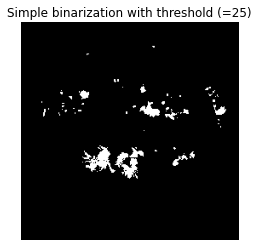

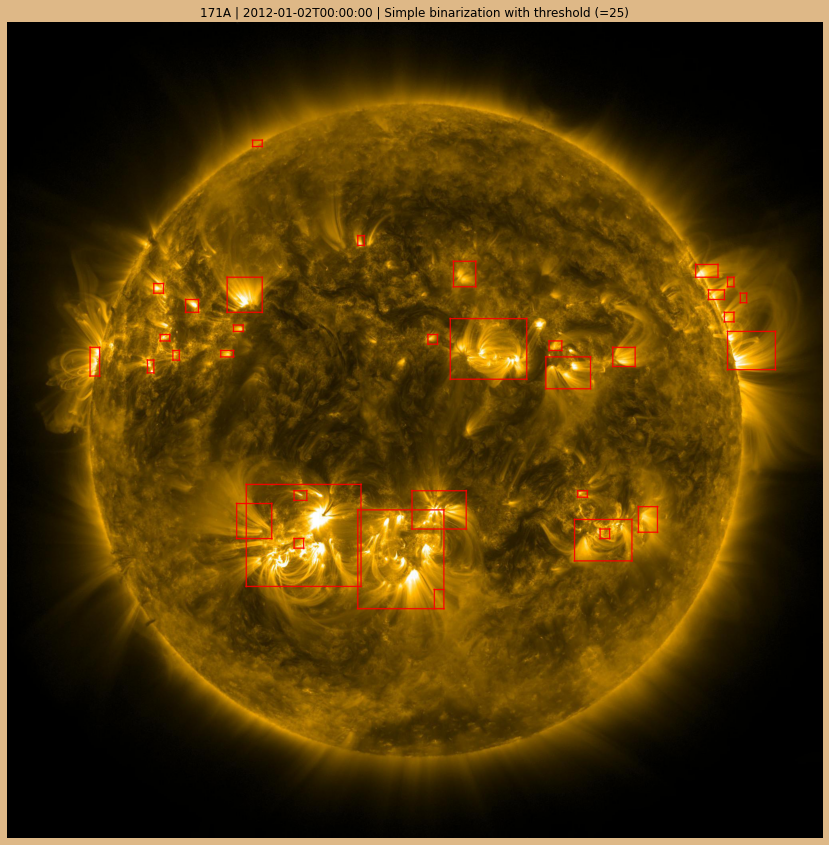

In [179]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="binary", scale=8, mask_threshold=25, title="Simple binarization with threshold (=25)")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Simple binarization with threshold (=25)")

## Simple binarization with threshold and Gaussian filter (=25, (5,5))

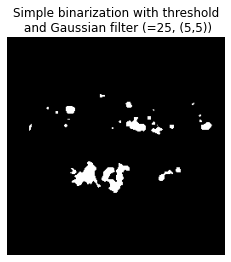

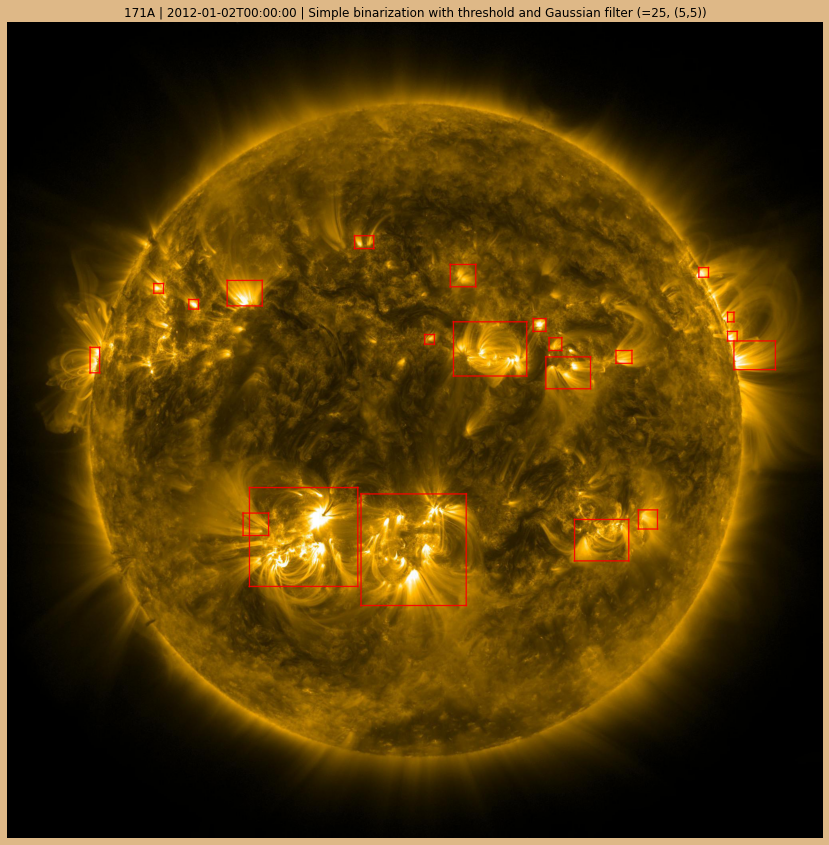

In [180]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="binary", scale=8, mask_threshold=25, gaussian_filter=True, title="Simple binarization with threshold\n and Gaussian filter (=25, (5,5))")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Simple binarization with threshold and Gaussian filter (=25, (5,5))")

## Otsu's Binarization

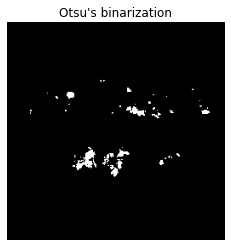

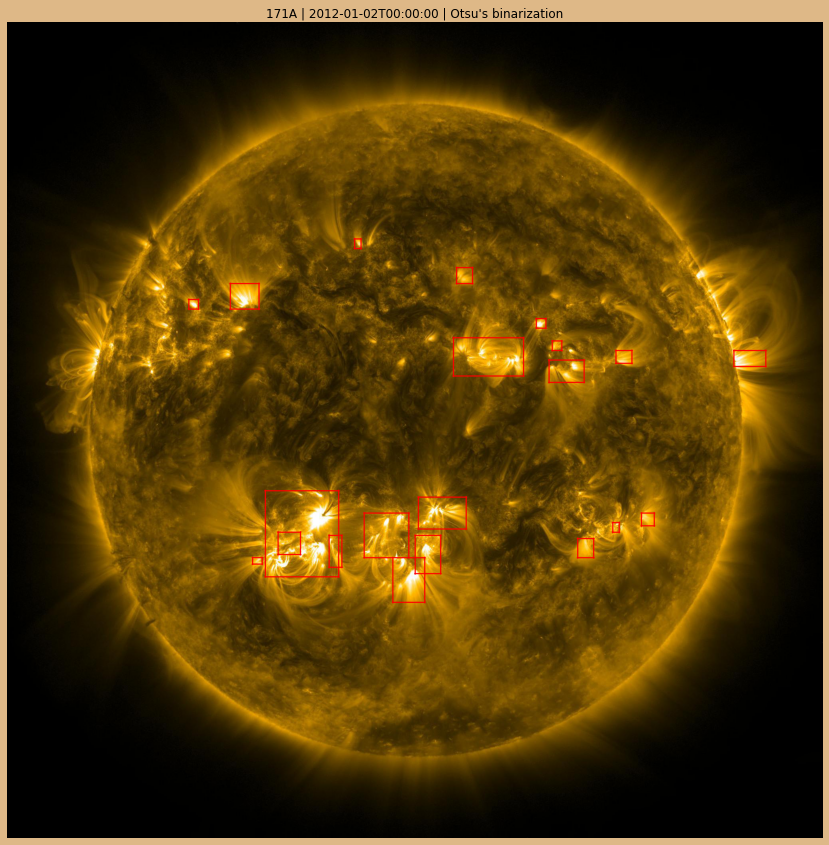

In [181]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="otsu", scale=8, title="Otsu's binarization")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Otsu's binarization")

## Otsu's Binarization with Gaussian filtering

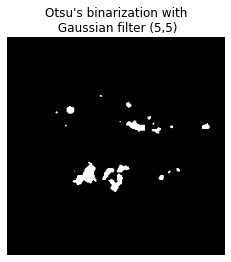

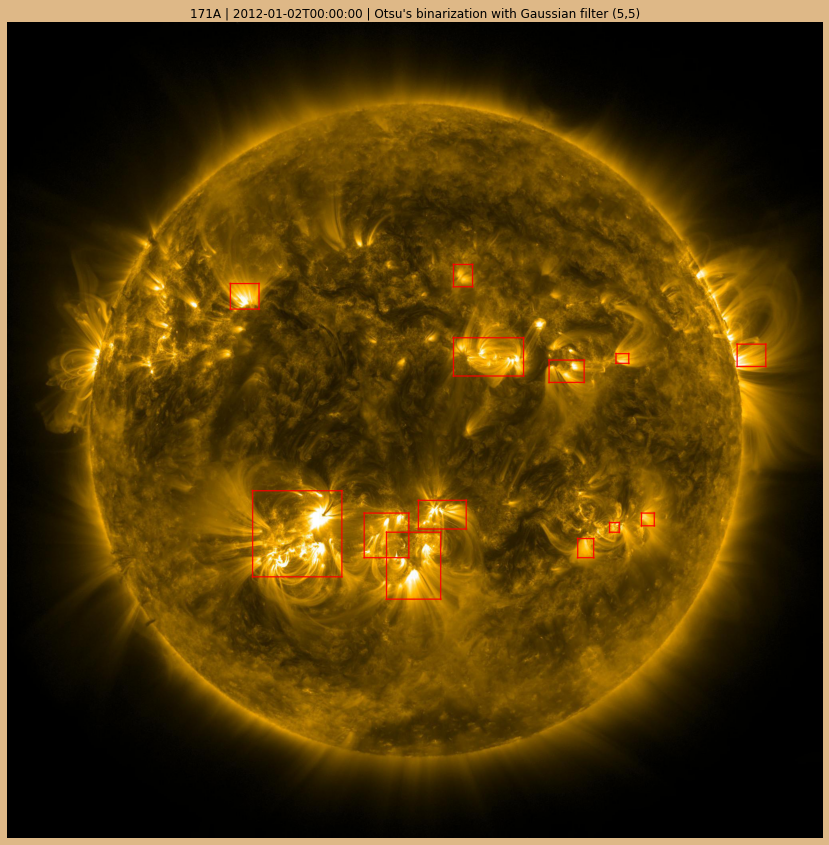

In [182]:
anomaly_boxes = extract_bounding_boxes_from_anomaly_map(map_path, mode="otsu", scale=8, gaussian_filter=True, title="Otsu's binarization with\n Gaussian filter (5,5)")
show_img_with_bounding_boxes(src_img_path, anomaly_boxes, 171, "2012-01-02T00:00:00 | Otsu's binarization with Gaussian filter (5,5)")

- https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html